## Modeling the data

This notebook is where I try different models on my finalized data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Dropout, Flatten, GlobalAveragePooling2D

import os
import time

In [ ]:
# mount to Google Drive
# data is saved in the test_data folder of my Drive, link is in README for anyone to access.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g4MGszHnQMaCbmBw1U7JzGDnW18dOhPsfavyuJ3QbrC6EI7pEFKiPI


In order to get the most out of the images I upload, I want to add augmentation to all.

In [ ]:
image_gen = ImageDataGenerator(rescale = 1/255.,
                               horizontal_flip=True, 
                               vertical_flip=True,
                               rotation_range=20,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               validation_split=0.2
                               )

The validation split parameter allows me to load in training data and validation data separately. I chose 20% validation.

In [ ]:
train_data = image_gen.flow_from_directory('drive/MyDrive/capstone_translator/test_data',
                                           target_size=(150, 150),
                                           shuffle=False,
                                           subset='training')

Found 24354 images belonging to 30 classes.


In [ ]:
val_data = image_gen.flow_from_directory('drive/MyDrive/capstone_translator/test_data', 
                                         target_size=(150, 150),
                                         shuffle=False,
                                         subset='validation')

Found 6074 images belonging to 30 classes.


In [ ]:
train_data[0][0].shape

(32, 150, 150, 3)

### Beginning the models

I tested creating my own Neural Network. I only did this up until the addition of 5 words.

*   3 words - 82% accuracy (Xception - 87% accuracy)
*   5 words - 70% accuracy (Xception - 96% accuracy)

Inspiration pulled from:
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html








In [ ]:
# adding a callback parameter to stop the model if it does not improve 5 epochs in a row
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 32,kernel_size = (3,3), activation = 'relu', input_shape = (150,150,3)))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(filters = 64,kernel_size = (3,3), activation = 'relu', input_shape = (3, 3)))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(300, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(100, activation = 'relu'))

model.add(Dense(30, activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])



In [ ]:
history = model.fit(train_data,
                    validation_data = val_data,
                    callbacks=[callback],
                    epochs = 20)

In [ ]:
model.save('drive/MyDrive/capstone_translator/model.h5')

The below evaluations are based on my testing with the first 3 words: bed, cat, chair.

In [ ]:
# predictions based on model
preds = np.argmax(model.predict(val_data), axis=-1)

In [ ]:
# grab actuals for the validation data
actuals = val_data.labels

In [ ]:
# combine predictions and actuals to create a dataframe in order to compare how each word does individually
compare = pd.DataFrame({'preds': preds, 'actuals': actuals})
compare['accuracy'] = np.where(compare['preds'] == compare['actuals'], 1, 0)
compare.groupby('actuals')['accuracy'].mean()

actuals
0    0.730000
1    0.945098
2    0.833333
Name: accuracy, dtype: float64

In [ ]:
data_path = 'drive/MyDrive/capstone_translator/test_data'
for folder in os.listdir(data_path):
  count = len(os.listdir(f'drive/MyDrive/capstone_translator/test_data/{folder}'))
  print(f'{folder}: {count}')

bed: 1500
chair: 1562
cat: 1276


The words are numbered in alphabetical order, so even though "cat" has the least amount of images at 1276, it still shows that it gets the highest accuracy at 94.5%. From this I can assume that bed and chair are often confused because they are both furniture. Cats are easier to identify from the other two.

In [ ]:
# updated list of the final 30 words used in project
!ls drive/MyDrive/capstone_translator/test_data

airplanes   cabinet  dog	      fire_extinguisher  light_bulb    shirt
basket_bin  car      door	      flower		 microwave     shoes
bed	    cat      dress	      headphones	 motorbikes    shorts
bench	    chair    electric_socket  house_plant	 pants	       table
book	    clock    fan	      lamp		 refrigerator  watch


Neural Net with Xception, convolution base used to predict triaining data before adding to model fit.

In [ ]:
from tensorflow.keras.applications import MobileNetV2, VGG16, InceptionV3, Xception

In [ ]:
pre_trained_model = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(150, 150, 3))

 # the top is the part that we don't need, the classification - we will set our own

83689472/83683744 [==============================] - 1s 0us/step


In [ ]:
train_preds = pre_trained_model.predict(train_data)
val_preds = pre_trained_model.predict(val_data)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [ ]:
y_train = train_data.labels 
y_val = val_data.labels

In [ ]:
y_train_categories = tf.keras.utils.to_categorical(y_train)
y_val_categories = tf.keras.utils.to_categorical(y_val)

In [ ]:
#since we didn't include the given top, we make our own and stick it to the bottom
model = Sequential()

model.add(GlobalAveragePooling2D())
model.add(Dense(100, activation = 'relu'))

model.add(Dense(30, activation = 'softmax'))

In [ ]:
model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

In [ ]:
history = model.fit(train_preds, y_train_categories, 
                    validation_data=(val_preds, y_val_categories),
                    
                    epochs = 15)

Epoch 1/15
762/762 [==============================] - 7s 7ms/step - loss: 1.2229 - accuracy: 0.6732 - val_loss: 0.6325 - val_accuracy: 0.8128
Epoch 2/15
762/762 [==============================] - 5s 6ms/step - loss: 0.4720 - accuracy: 0.8582 - val_loss: 0.5675 - val_accuracy: 0.8311
Epoch 3/15
762/762 [==============================] - 5s 6ms/step - loss: 0.3416 - accuracy: 0.8940 - val_loss: 0.5208 - val_accuracy: 0.8452
Epoch 4/15
762/762 [==============================] - 5s 6ms/step - loss: 0.2415 - accuracy: 0.9258 - val_loss: 0.5008 - val_accuracy: 0.8505
Epoch 5/15
762/762 [==============================] - 5s 6ms/step - loss: 0.1659 - accuracy: 0.9509 - val_loss: 0.5073 - val_accuracy: 0.8564
Epoch 6/15
762/762 [==============================] - 5s 6ms/step - loss: 0.1439 - accuracy: 0.9581 - val_loss: 0.5469 - val_accuracy: 0.8582
Epoch 7/15
762/762 [==============================] - 5s 7ms/step - loss: 0.0874 - accuracy: 0.9754 - val_loss: 0.5862 - val_accuracy: 0.8507
Epoch 

In [ ]:
# results for validation set with 30 word classes
model.evaluate(val_preds, y_val_categories)

190/190 [==============================] - 1s 5ms/step - loss: 0.8229 - accuracy: 0.8550


[0.82290118932724, 0.8549555540084839]

In [ ]:
# save model to use in application
model.save('drive/MyDrive/capstone_translator/model_612_30.h5')

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               204900    
_________________________________________________________________
dense_4 (Dense)              (None, 30)                3030      
Total params: 207,930
Trainable params: 207,930
Non-trainable params: 0
_________________________________________________________________


Below I test how my application will work with new images uploaded.

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions
from PIL import Image

In [ ]:
# load image
im = Image.open('drive/MyDrive/capstone_translator/test_data/book/70.jpg')

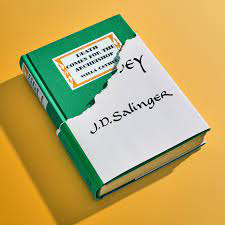

In [ ]:
# view image
im

In [ ]:
type(im)

PIL.JpegImagePlugin.JpegImageFile

I resize and check the shape to make sure it matches my model.

In [ ]:
imar = image.img_to_array(im)/255.

In [ ]:
imar.resize(150, 150, 3)
imar = np.expand_dims(imar, axis=0)
imar.shape

(1, 150, 150, 3)

In [ ]:
xt = pre_trained_model.predict(imar)

In [ ]:
pred = np.argmax(model.predict(xt), axis = 1)
pred

array([4])